In [1]:
#pip install -e .

Obtaining file:///Users/pierrejunca/code/Dekkerz/mocap
  Preparing metadata (setup.py) ... done
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow (from mocap) (from versions: none)
ERROR: No matching distribution found for tensorflow

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

from scipy import stats

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import  Dense, Dropout, Flatten, Reshape, LSTM, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from tensorflow import keras
from tensorflow.keras.metrics import Recall, Precision

import seaborn as sns

In [6]:
xls_dir="UT_Smoking_Data"
P1_Data_path = os.path.join(xls_dir+"/" + "Participant1_Data.xlsx")

In [7]:
data_1=pd.read_excel(P1_Data_path, header=None)
data_1

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1455278271218,-5.973572,-6.710114,2.555145,-0.474457,0.382236,0.345239,-0.014404,-0.001846,-0.028992,...,-0.161003,0.038790,0.006414,-0.004276,13.9375,39.0000,-26.2500,52.238673,6.857011,SmokeSD
1,1455278271238,-5.980713,-6.838654,2.605133,-0.471420,0.249793,0.383285,0.001617,-0.005051,-0.027924,...,-0.136580,0.037568,0.025351,-0.010079,13.8750,39.0000,-26.2500,52.238673,6.857011,SmokeSD
2,1455278271258,-6.025940,-6.895783,2.514679,-0.504273,0.187889,0.285115,0.009094,-0.015732,-0.027924,...,-0.116517,0.033292,0.027184,-0.009774,13.8750,38.6875,-26.2500,52.238673,6.857011,SmokeSD
3,1455278271279,-5.956909,-7.031464,2.752716,-0.424346,0.048824,0.503679,0.019775,-0.015732,-0.015106,...,-0.053767,0.021380,0.025351,-0.009774,13.8125,38.8750,-26.2500,52.238673,6.857011,SmokeSD
4,1455278271298,-5.959290,-6.900543,2.743195,-0.414628,0.176953,0.475054,0.006958,-0.013596,-0.004425,...,-0.207327,0.023824,0.053145,-0.015577,13.8125,38.6875,-26.2500,52.238673,6.857011,SmokeSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904395,1461602683308,9.681763,-1.978455,-0.256821,-0.134968,-0.414399,0.267209,0.146683,-0.002441,-0.181915,...,-0.002465,-0.004276,-0.078802,-0.013439,-10.6250,13.8125,-42.2500,0.000000,0.000000,Stand
904396,1461602683329,9.865051,-1.980835,-0.268723,0.076663,-0.508131,0.216074,0.150955,0.010376,-0.156281,...,-0.061307,-0.004581,-0.056505,-0.010385,-10.7500,14.0000,-42.0000,0.000000,0.000000,Stand
904397,1461602683348,10.057861,-2.002258,-0.361557,0.315035,-0.547142,0.158731,0.115707,0.043488,-0.106079,...,-0.199140,-0.027489,-0.047953,-0.010996,-10.5000,13.9375,-42.0625,0.000000,0.000000,Stand
904398,1461602683369,10.045959,-1.964172,-0.349655,0.272425,-0.496381,0.132929,0.087936,0.065918,-0.056946,...,-0.022247,-0.046731,-0.015272,0.004581,-10.3750,13.9375,-41.9375,0.000000,0.000000,Stand


In [8]:
d = {0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 2:'Accelerometer_y_WD', 3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 5:'Linear_acceleration_sensor_y_WD', 6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 8:'Gyroscope_y_WD', 9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 11:'Magnetometer_y_WD', 12:'Magnetometer_z_WD', 
     13:'Pressure_sensor_WD', 14:'Heart_rate_sensor_WD',
    15:'GAP', 
     16:'timestamp_PD', 
     17:'Accelerometer_x_PD', 18:'Accelerometer_y_PD', 19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 21:'Linear_acceleration_sensor_y_PD', 22:'Linear_acceleration_sensor_z_PD', 
     23:'Gyroscope_x_PD', 24:'Gyroscope_y_PD',25:'Gyroscope_z_PD', 
     26:'Magnetometer_x_PD', 27:'Magnetometer_y_PD', 28:'Magnetometer_z_PD', 
     29:'GPS_lat_PD',30:'GPS_long_PD', 
     31:'Class_label'}

In [9]:
P1_data = data_1.rename(d, axis=1)

In [10]:
label_class = {'SmokeSD':0
                ,'SmokeST':1
                ,'Eat':2
                ,'DrinkSD':3
                ,'DrinkST':4
                ,'Sit':5
                ,'Stand':6
                }

In [11]:
P1_data['Class'] = P1_data['Class_label'].map(label_class)

In [12]:
def scrub_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    clean raw data by removing buggy or irrelevant transactions
    or columns for the training set
    """
    participant_num=''.join([d for d in re.findall(r'\d+',"")])
    df['Participant_Num']=participant_num

    # remove useless/redundant columns
    df = df.drop(columns=['timestamp_WD'
                    ,'GAP'
                    ,'timestamp_PD'
                    ,'Accelerometer_x_PD'
                    ,'Accelerometer_y_PD'
                    ,'Accelerometer_z_PD'
                    ,'Linear_acceleration_sensor_x_PD'
                    ,'Linear_acceleration_sensor_y_PD'
                    ,'Linear_acceleration_sensor_z_PD'
                    ,'Gyroscope_x_PD'
                    ,'Gyroscope_y_PD'
                    ,'Gyroscope_z_PD'
                    ,'Magnetometer_x_PD'
                    ,'Magnetometer_y_PD'
                    ,'Magnetometer_z_PD'
                    ,'GPS_lat_PD'
                    ,'GPS_long_PD'])

    print("\n✅ data cleaned")

    return df

In [13]:
df = scrub_data(P1_data)


✅ data cleaned


In [14]:
df

,Accelerometer_x_WD,Accelerometer_y_WD,Accelerometer_z_WD,Linear_acceleration_sensor_x_WD,Linear_acceleration_sensor_y_WD,Linear_acceleration_sensor_z_WD,Gyroscope_x_WD,Gyroscope_y_WD,Gyroscope_z_WD,Magnetometer_x_WD,Magnetometer_y_WD,Magnetometer_z_WD,Pressure_sensor_WD,Heart_rate_sensor_WD,Class_label,Class,Participant_Num
0,-5.973572,-6.710114,2.555145,-0.474457,0.382236,0.345239,-0.014404,-0.001846,-0.028992,15.905762,41.093445,3.219604,997.52484,84,SmokeSD,0,
1,-5.980713,-6.838654,2.605133,-0.471420,0.249793,0.383285,0.001617,-0.005051,-0.027924,15.916443,41.191100,3.067017,997.47235,84,SmokeSD,0,
2,-6.025940,-6.895783,2.514679,-0.504273,0.187889,0.285115,0.009094,-0.015732,-0.027924,15.763855,42.268370,2.624512,997.40674,84,SmokeSD,0,
3,-5.956909,-7.031464,2.752716,-0.424346,0.048824,0.503679,0.019775,-0.015732,-0.015106,16.072083,41.833496,3.517151,997.43300,84,SmokeSD,0,
4,-5.959290,-6.900543,2.743195,-0.414628,0.176953,0.475054,0.006958,-0.013596,-0.004425,16.108704,41.365050,3.822327,997.40674,84,SmokeSD,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904395,9.681763,-1.978455,-0.256821,-0.134968,-0.414399,0.267209,0.146683,-0.002441,-0.181915,-20.312500,81.712340,27.458190,997.30130,0,Stand,6,
904396,9.865051,-1.980835,-0.268723,0.076663,-0.508131,0.216074,0.150955,0.010376,-0.156281,-21.047974,82.527160,26.156616,997.36100,0,Stand,6,
904397,10.057861,-2.002258,-0.361557,0.315035,-0.547142,0.158731,0.115707,0.043488,-0.106079,-21.578980,82.846070,25.646973,997.36740,0,Stand,6,
904398,10.045959,-1.964172,-0.349655,0.272425,-0.496381,0.132929,0.087936,0.065918,-0.056946,-21.786499,82.226560,26.109314,997.31860,0,Stand,6,


In [15]:
def create_segments_and_labels(df, time_steps, step):

    # x, y, z acceleration as features
    n_features = 3
    # Each generated sequence contains 200 training examples
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['Accelerometer_x_WD'].values[i: i + time_steps]
        ys = df['Accelerometer_y_WD'].values[i: i + time_steps]
        zs = df['Accelerometer_z_WD'].values[i: i + time_steps]
        # Retrieve the most often used label in each segment
        label = stats.mode(df['Class'][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels =np.asarray(pd.get_dummies(labels), dtype = np.float32)

    return reshaped_segments, labels

In [17]:
reshaped_segments, labels = create_segments_and_labels(df, 1500, 500)

/tmp/ipykernel_11673/1238486949.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['Class'][i: i + time_steps])[0][0]


In [18]:
print(reshaped_segments.shape, labels.shape)

(1806, 1500, 3) (1806, 7)


In [71]:

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(reshaped_segments, 
                                                                    labels, test_size=0.7, 
                                                                    random_state=42)

X_train_res, X_train_val, y_train_res, y_train_val = train_test_split(X_train_res, 
                                                                    y_train_res, test_size=0.3, 
                                                                    random_state=42)

num_time_periods, num_sensors = X_train_res.shape[1], X_train_res.shape[2]
input_shape = (num_time_periods*num_sensors)
print('input_shape:', input_shape)

num_classes = 7
print('input_shape:', input_shape)


#X_train_val = X_train_res.reshape(X_train_res.shape[0], input_shape)
#X_test_val = X_test_res.reshape(X_test_res.shape[0], input_shape)
#X_train_val= X_train_val.astype('float32')
#y_train_val = y_train_res.astype('float32')
#X_test_val = X_test_val.astype('float32')
#y_test_val = y_test_res.astype('float32')

input_shape: 4500
input_shape: 4500


In [72]:
num_classes = 7
time_steps = 1500
input_shape = X_train_res.shape[1:]
n_neuron= 100
print(input_shape)

(1500, 3)


In [81]:
print('x_train shape:', X_train_res.shape)
print('y_train shape:', y_train_res.shape)
print('\n')

print('x_train_val shape:', X_train_val.shape)
print('y_train_val shape:', y_train_val.shape)
print('\n')

print('x_test shape:', X_test_res.shape)
print('y_test shape:', y_test_res.shape)

# Set input & output dimensions
num_time_periods, num_sensors = X_train_res.shape[1], X_train_res.shape[2]
num_classes = 7

x_train shape: (378, 1500, 3)
y_train shape: (378, 7)


x_train_val shape: (163, 1500, 3)
y_train_val shape: (163, 7)


x_test shape: (1265, 1500, 3)
y_test shape: (1265, 7)


In [34]:
do_this=False

# summarize history for accuracy
if do_this :
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [36]:
lstm_neurons= 100
dense_neurons= 100
drop_out= 0.5

In [61]:
def make_cnn_lstm_model(lstm_neurons,dense_neurons,drop_out):
    
    metrics = [  keras.metrics.Recall(), 
                 keras.metrics.Precision(),
                 keras.metrics.AUC(name='prc', curve='PR') ]
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'),  input_shape=(n_steps,n_length, 3)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(drop_out)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(lstm_neurons))
    model.add(Dropout(drop_out)) 
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    
    return model

In [83]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 150,10

X_train_cnn = X_train_res.reshape((X_train_res.shape[0], n_steps, n_length, 3))
X_train_val_cnn = X_train_val.reshape((X_train_val.shape[0], n_steps, n_length, 3))
X_test_cnn = X_test_res.reshape((X_test_res.shape[0], n_steps, n_length, 3))

In [77]:
try:
  del model_cnn_lstm
except:
  pass

model_cnn_lstm = make_cnn_lstm_model(lstm_neurons= 100, dense_neurons = 100, drop_out = 0.5)
print(model_cnn_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 150, 8, 64)       640       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 150, 6, 64)       12352     
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 150, 6, 64)       0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 150, 3, 64)       0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 150, 192)        

In [78]:
X_train_cnn.shape

(378, 150, 10, 3)

In [84]:
es = EarlyStopping(monitor="val_loss",
                       patience=10,
                       restore_best_weights=True,
                       verbose=0)

cnn_lstm = model_cnn_lstm.fit(X_train_cnn, y_train_res, batch_size=64,
                      epochs=50, callbacks=[es], validation_data=(X_train_val_cnn, y_train_val) ,verbose=1)

Epoch 1/50
6/6 [==============================] - 7s 548ms/step - loss: 1.8627 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - prc: 0.2093 - val_loss: 1.6262 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_prc: 0.4591
Epoch 2/50
6/6 [==============================] - 2s 349ms/step - loss: 1.6333 - recall_2: 0.0370 - precision_2: 0.8235 - prc: 0.3606 - val_loss: 1.4765 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_prc: 0.5024
Epoch 3/50
6/6 [==============================] - 2s 352ms/step - loss: 1.4885 - recall_2: 0.0794 - precision_2: 0.7500 - prc: 0.4370 - val_loss: 1.3760 - val_recall_2: 0.0184 - val_precision_2: 0.6000 - val_prc: 0.5251
Epoch 4/50
6/6 [==============================] - 2s 355ms/step - loss: 1.3347 - recall_2: 0.1481 - precision_2: 0.7368 - prc: 0.5063 - val_loss: 1.2637 - val_recall_2: 0.2331 - val_precision_2: 0.8837 - val_prc: 0.5979
Epoch 5/50
6/6 [==============================] - 2s 402ms/step - loss: 1.1812 - recall_2: 0.232

In [86]:
def plot_history(history, optimizer_str, axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    pkey="precision"; vpkey="val_precision"
    for key in history.history.keys():
      if key.startswith("precision")       : pkey=key; 
      elif key.startswith("val_precision") : vpkey=key; 
        
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
               
    ax2.plot(history.history[pkey], label='train accuracy'  + exp_name)
    ax2.plot(history.history[vpkey], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy ' + optimizer_str)
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot: title={'center': 'loss'}>,
 <AxesSubplot: title={'center': 'Accuracy adam'}>)

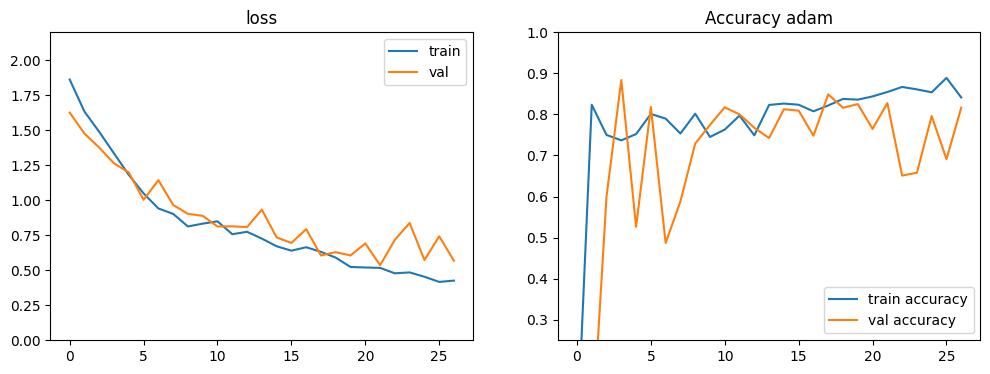

In [87]:
plot_history(cnn_lstm, "adam")

In [89]:
# Print confusion matrix for training data
y_pred_train = model_cnn_lstm.predict(X_train_cnn)

# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)

print(classification_report(max_train, max_y_pred_train))

12/12 [==============================] - 1s 71ms/step
              precision    recall  f1-score   support

           0       0.59      0.96      0.73        47
           1       0.68      0.49      0.57        47
           2       0.71      0.98      0.82        50
           3       0.68      0.40      0.50        58
           4       0.94      0.80      0.86        55
           5       0.98      0.93      0.95        55
           6       1.00      1.00      1.00        66

    accuracy                           0.80       378
   macro avg       0.80      0.79      0.78       378
weighted avg       0.81      0.80      0.79       378



In [91]:
score = model_cnn_lstm.evaluate(X_test_cnn, y_test_res, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

40/40 [==============================] - 3s 65ms/step - loss: 0.5776 - recall_2: 0.7628 - precision_2: 0.8262 - prc: 0.8843

Accuracy on test data: 0.76

Loss on test data: 0.58


In [92]:
def confusion_matrix_plot(y, y_pred):
    labels=['SmokeSD', 'SmokeST', 'Eat', 'DrinkSD', 'DrinkST', 'Sit', 'Stand']
    matrix = metrics.confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 7))
    ax= sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

40/40 [==============================] - 2s 62ms/step
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       187
           1       0.82      0.39      0.53       189
           2       0.67      0.96      0.79       183
           3       0.75      0.61      0.67       178
           4       0.94      0.74      0.83       176
           5       0.97      0.95      0.96       177
           6       0.98      1.00      0.99       175

    accuracy                           0.80      1265
   macro avg       0.83      0.80      0.79      1265
weighted avg       0.82      0.80      0.79      1265



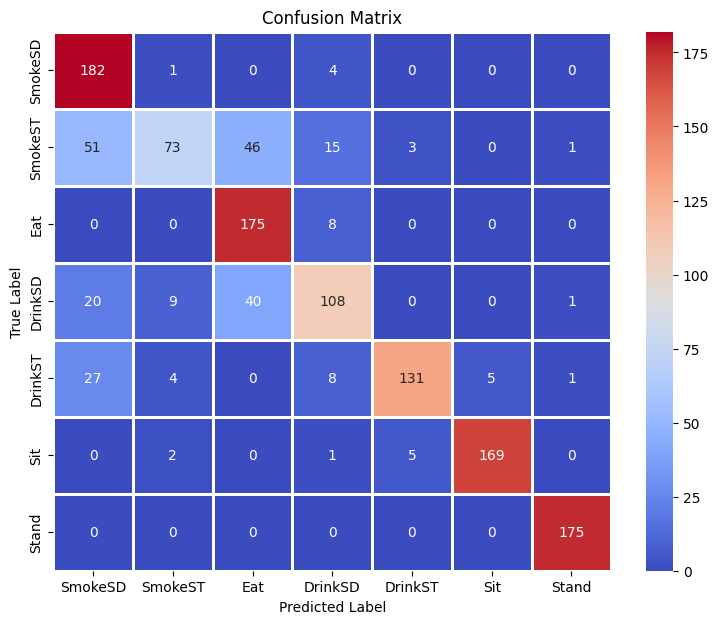

In [93]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_cnn_lstm.predict(X_test_cnn)

max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_res, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix_plot(max_y_test, max_y_pred_test)

In [134]:
max_y_pred_test.shape

(542,)

In [135]:
max_y_test.shape

(542,)